In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import LSTM, Dense
from sklearn.metrics import mean_squared_error

In [14]:
# Step 1: Read the CSV file
file_path = 'HistoricalData_1721543882668.csv'
data = pd.read_csv(file_path)



In [15]:
# Step 2: Preprocess the data
data['Date'] = pd.to_datetime(data['Date'])
data['Close/Last'] = data['Close/Last'].str.replace('$', '').astype(float)
data['Open'] = data['Open'].str.replace('$', '').astype(float)
data['High'] = data['High'].str.replace('$', '').astype(float)
data['Low'] = data['Low'].str.replace('$', '').astype(float)
data = data.sort_values('Date')




In [16]:
# Step 3: Normalize the data
scaler = MinMaxScaler(feature_range=(0, 1))
data['Close/Last'] = scaler.fit_transform(data['Close/Last'].values.reshape(-1, 1))



In [17]:
# Prepare the data for the LSTM model
def create_dataset(dataset, look_back=1):
    X, Y = [], []
    for i in range(len(dataset) - look_back - 1):
        a = dataset[i:(i + look_back), 0]
        X.append(a)
        Y.append(dataset[i + look_back, 0])
    return np.array(X), np.array(Y)

look_back = 60
dataset = data['Close/Last'].values.reshape(-1, 1)
train_size = int(len(dataset) * 0.8)
test_size = len(dataset) - train_size
train, test = dataset[0:train_size, :], dataset[train_size:len(dataset), :]

trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)



In [18]:
# Reshape input to be [samples, time steps, features]
trainX = np.reshape(trainX, (trainX.shape[0], trainX.shape[1], 1))
testX = np.reshape(testX, (testX.shape[0], testX.shape[1], 1))



In [19]:
# Step 4: Build and train the LSTM model
model = Sequential()
model.add(LSTM(50, return_sequences=True, input_shape=(look_back, 1)))
model.add(LSTM(50))
model.add(Dense(1))
model.compile(loss='mean_squared_error', optimizer='adam')
model.fit(trainX, trainY, epochs=20, batch_size=1, verbose=2)



Epoch 1/20
1952/1952 - 15s - loss: 1.0047e-04 - 15s/epoch - 8ms/step
Epoch 2/20
1952/1952 - 13s - loss: 4.7830e-05 - 13s/epoch - 6ms/step
Epoch 3/20
1952/1952 - 13s - loss: 3.3377e-05 - 13s/epoch - 7ms/step
Epoch 4/20
1952/1952 - 13s - loss: 2.6177e-05 - 13s/epoch - 7ms/step
Epoch 5/20
1952/1952 - 12s - loss: 2.8431e-05 - 12s/epoch - 6ms/step
Epoch 6/20
1952/1952 - 13s - loss: 2.1429e-05 - 13s/epoch - 7ms/step
Epoch 7/20
1952/1952 - 13s - loss: 2.0333e-05 - 13s/epoch - 6ms/step
Epoch 8/20
1952/1952 - 13s - loss: 1.9500e-05 - 13s/epoch - 7ms/step
Epoch 9/20
1952/1952 - 12s - loss: 2.1558e-05 - 12s/epoch - 6ms/step
Epoch 10/20
1952/1952 - 12s - loss: 2.0156e-05 - 12s/epoch - 6ms/step
Epoch 11/20
1952/1952 - 12s - loss: 1.5301e-05 - 12s/epoch - 6ms/step
Epoch 12/20
1952/1952 - 13s - loss: 1.8083e-05 - 13s/epoch - 6ms/step
Epoch 13/20
1952/1952 - 13s - loss: 1.8262e-05 - 13s/epoch - 6ms/step
Epoch 14/20
1952/1952 - 13s - loss: 1.7005e-05 - 13s/epoch - 6ms/step
Epoch 15/20
1952/1952 - 13s -

In [20]:
# Step 5: Evaluate the model
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)



14/14 [==============================] - 1s 3ms/step


In [21]:
# Invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])



In [22]:
# Calculate root mean squared error
trainScore = np.sqrt(mean_squared_error(trainY[0], trainPredict[:, 0]))
testScore = np.sqrt(mean_squared_error(testY[0], testPredict[:, 0]))
print(f'Train Score: {trainScore:.2f} RMSE')
print(f'Test Score: {testScore:.2f} RMSE')



Train Score: 0.49 RMSE
Test Score: 7.73 RMSE


In [23]:
# Step 6: Visualize the results
trainPredictPlot = np.empty_like(dataset)
trainPredictPlot[:, :] = np.nan
trainPredictPlot[look_back:len(trainPredict) + look_back, :] = trainPredict

testPredictPlot = np.empty_like(dataset)
testPredictPlot[:, :] = np.nan
testPredictPlot[len(trainPredict) + (look_back * 2) + 1:len(dataset) - 1, :] = testPredict



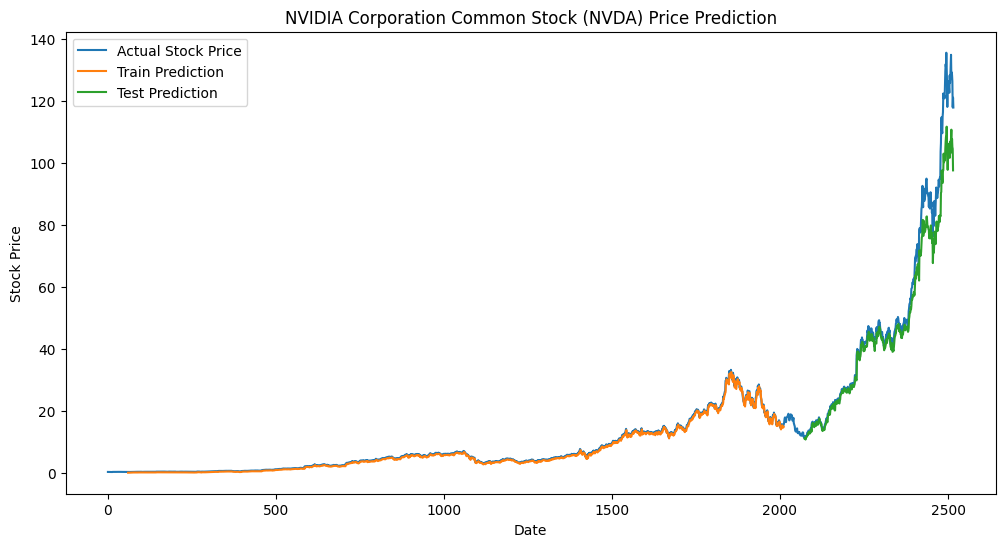

In [24]:
# Plot baseline and predictions
plt.figure(figsize=(12, 6))
plt.plot(scaler.inverse_transform(dataset), label='Actual Stock Price')
plt.plot(trainPredictPlot, label='Train Prediction')
plt.plot(testPredictPlot, label='Test Prediction')
plt.xlabel('Date')
plt.ylabel('Stock Price')
plt.title('NVIDIA Corporation Common Stock (NVDA) Price Prediction')
plt.legend()
plt.show()